In [40]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, Dropout, Convolution2D, GlobalAveragePooling2D
from keras.models import Sequential
import tensorflow as tf
import tensorflow.keras.applications.mobilenet
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
dataset_path = '/content/drive/MyDrive/Skin_sample_Data/train/'

In [43]:
classes = {'Actinic keratosis': 0,'Atopic Dermatitis': 1,'Benign keratosis': 2,'Dermatofibroma': 3,'Melanocytic nevus': 4,'Melanoma':5,'Squamous cell carcinoma': 6,'Tinea Ringworm Candidiasis':7,
          'Vascular lesion': 8
}

In [44]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [45]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Skin_sample_Data/train/',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 shuffle = False,
                                                 class_mode = 'categorical')

Found 697 images belonging to 9 classes.


In [46]:
from sklearn.utils import shuffle

In [82]:
import cv2
img_size=224
def resize_to_square(image, size):
    h, w, c = image.shape
    ratio = size / max(h, w)
    resized_image = cv2.resize(image, (int(w*ratio), int(h*ratio)), cv2.INTER_AREA)
    return resized_image
def padding(image, min_height, min_width):
    h, w, c = image.shape

    if h < min_height:
        h_pad_top = int((min_height - h) / 2.0)
        h_pad_bottom = min_height - h - h_pad_top
    else:
        h_pad_top = 0
        h_pad_bottom = 0

    if w < min_width:
        w_pad_left = int((min_width - w) / 2.0)
        w_pad_right = min_width - w - w_pad_left
    else:
        w_pad_left = 0
        w_pad_right = 0

    return cv2.copyMakeBorder(image, h_pad_top, h_pad_bottom, w_pad_left, w_pad_right, cv2.BORDER_CONSTANT, value=(0,0,0))

def load_data(directory):
    output = []
    images = []
    labels = []
    file_names = []
    for folder in sorted(os.listdir(directory)):
        print("***",folder)
        curr_label=classes[folder]
        for file in os.listdir(directory + "/" + folder):
            img_path = directory + "/" + folder + "/" + file
            curr_img = cv2.imread(img_path)
            curr_img = resize_to_square(curr_img, img_size)
            curr_img = padding(curr_img, img_size, img_size)
            images.append(curr_img)
            labels.append(curr_label)
            file_names.append(file)
    #images, labels, file_names = shuffle(images, labels, file_names, random_state=817328462)     ### Shuffle the data !!!
    images = np.array(images, dtype = 'float32') ### Our images
    labels = np.array(labels, dtype = 'int32')   ### From 0 to num_classes-1!

    return images, labels, file_names

print(dataset_path)
images, labels, file_names=load_data(dataset_path)

/content/drive/MyDrive/Skin_sample_Data/train/
*** Actinic keratosis
*** Atopic Dermatitis
*** Benign keratosis
*** Dermatofibroma
*** Melanocytic nevus
*** Melanoma
*** Squamous cell carcinoma
*** Tinea Ringworm Candidiasis
*** Vascular lesion


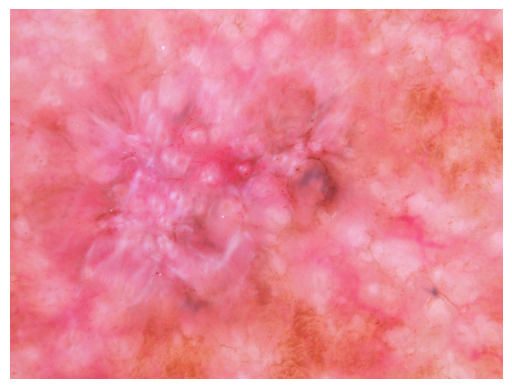

In [81]:
import matplotlib.pyplot as plt
img_path='/content/drive/MyDrive/Skin_sample_Data/train//Actinic keratosis/ISIC_0024468.jpg'
curr_img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(curr_img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels and ticks
plt.show()


In [83]:
val_dataset_path='/content/drive/MyDrive/Skin_sample_Data/val/'
val_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


validation_set = val_datagen.flow_from_directory('/content/drive/MyDrive/Skin_sample_Data/val/',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 shuffle = False,
                                                 class_mode = 'categorical')

test_images,test_labels,test_file_names=load_data(val_dataset_path)

Found 181 images belonging to 9 classes.
*** Actinic keratosis
*** Atopic Dermatitis
*** Benign keratosis
*** Dermatofibroma
*** Melanocytic nevus
*** Melanoma
*** Squamous cell carcinoma
*** Tinea Ringworm Candidiasis
*** Vascular lesion


In [86]:
x_data = images
y_data = labels
print(x_data.shape)
print(y_data.shape)
print(y_data)


(697, 224, 224, 3)
(697,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.layers import Conv2D,MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.optimizers import SGD

In [51]:
from keras.utils import to_categorical
num_classes = 9
Y = to_categorical(y_data,num_classes)
X = x_data

In [52]:
X_train=X
y_train=Y

X_test=test_images
y_cat=to_categorical(test_labels,num_classes)
y_test=y_cat

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(697, 224, 224, 3)
(697, 9)
(181, 224, 224, 3)
(181, 9)


In [53]:
TRAINING_NUMBER = len(y_train)
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.005
MOMENTUM = 0.9
DECAY = 1e-6
num_channel = 3

In [54]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.applications.vgg16 import VGG16

image_input = Input(shape=(img_size,img_size,num_channel))
vgg_mod = VGG16(input_tensor=image_input, include_top=False,weights='imagenet')
vgg_mod.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [55]:
vgg_mod.trainable = False

for layer in vgg_mod.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True
    if layer.name == 'block4_conv1':
        layer.trainable = True
    else:
        layer.trainable = False

vgg_mod.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [56]:
add_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=vgg_mod.output_shape[1:]), # the nn will learn the good filter to use
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation=tf.nn.softmax)
])

model_vgg16 = Model(inputs=vgg_mod.input, outputs=add_model(vgg_mod.output))
model_vgg16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'],)
model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [57]:
from keras.callbacks import ReduceLROnPlateau

callbacks_list = [ReduceLROnPlateau(monitor='loss',factor=0.2,patience=3)]

In [58]:
hist_1=model_vgg16.fit(X_train,y_train,
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       callbacks = callbacks_list,
                       verbose=1)

Epoch 1/10
6/6 [==============================] - 5s 523ms/step - loss: 9.2213 - accuracy: 0.1664 - lr: 0.0010
Epoch 2/10
6/6 [==============================] - 3s 521ms/step - loss: 2.2365 - accuracy: 0.2769 - lr: 0.0010
Epoch 3/10
6/6 [==============================] - 3s 527ms/step - loss: 1.4640 - accuracy: 0.5007 - lr: 0.0010
Epoch 4/10
6/6 [==============================] - 3s 537ms/step - loss: 1.0807 - accuracy: 0.6141 - lr: 0.0010
Epoch 5/10
6/6 [==============================] - 3s 529ms/step - loss: 0.7891 - accuracy: 0.7217 - lr: 0.0010
Epoch 6/10
6/6 [==============================] - 3s 531ms/step - loss: 0.6336 - accuracy: 0.7704 - lr: 0.0010
Epoch 7/10
6/6 [==============================] - 3s 536ms/step - loss: 0.5361 - accuracy: 0.7920 - lr: 0.0010
Epoch 8/10
6/6 [==============================] - 3s 540ms/step - loss: 0.4972 - accuracy: 0.8135 - lr: 0.0010
Epoch 9/10
6/6 [==============================] - 3s 527ms/step - loss: 0.3869 - accuracy: 0.8422 - lr: 0.0010
E

In [59]:
#Testing result
score = model_vgg16.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7704229950904846
Test accuracy: 0.7679557800292969


In [97]:
#predicting
img_path='/content/drive/MyDrive/Skin_sample_Data/train/Benign keratosis/ISIC_0014589_downsampled.jpg'
img=image.load_img(img_path,target_size=(224,224))
img.show()

In [98]:
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

In [99]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [100]:
predictions = model_vgg16.predict(x)

1/1 [==============================] - 0s 21ms/step


In [101]:
predictions

array([[2.6679827e-06, 1.5805021e-05, 7.0571783e-04, 2.4348466e-07,
        3.7667380e-06, 3.1911772e-01, 2.8388122e-08, 6.8015045e-01,
        3.6538395e-06]], dtype=float32)

In [102]:
#decoded_predictions = decode_predictions(predictions, top=5)[0]
predicted_class_index = np.argmax(predictions)
predicted_class_index

7

In [103]:
classes=['Actinic keratosis','Atopic Dermatitis',
'Benign keratosis',
'Dermatofibroma',
'Melanocytic nevus',
'Melanoma',
'Squamous cell carcinoma',
'Tinea Ringworm Candidiasis',
'Vascular lesion']

In [104]:
print("Predicted class is ",classes[predicted_class_index])

Predicted class is  Tinea Ringworm Candidiasis
